# ENVIRONMENT SETUP

In [53]:
import sys, os
import importlib
import site
import json
import random
from datetime import datetime
from IPython.display import display, Markdown
user_site = os.path.expanduser("~/.local/lib/python3.10/site-packages")
if user_site not in sys.path:
    sys.path.append(user_site)
print(" Core libraries imported")
print(f" Working directory: {os.getcwd()}")

print("All packages installed")
importlib.reload(site)
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
try:
    import torch
    import kagglehub
    from transformers import CLIPTokenizer, CLIPTextModel, CLIPProcessor, CLIPModel
    from sklearn.metrics.pairwise import cosine_similarity
    from diffusers import (
        StableDiffusionPipeline, 
        DPMSolverMultistepScheduler,
        PNDMScheduler,
        EulerDiscreteScheduler,
        DDIMScheduler
    )
    import diffusers
    import transformers
    
    print(" PyTorch version:", torch.__version__)
    print(" Diffusers version:", diffusers.__version__)
    print(" Transformers version:", transformers.__version__)
except Exception as e:
    print(" Error importing packages:", e)

 Core libraries imported
 Working directory: /courses/IE7615.202610/students/swamy.ar/Project_2
All packages installed
 PyTorch version: 2.5.1
 Diffusers version: 0.32.2
 Transformers version: 4.49.0


# DOWNLOAD AND EXTRACT COCO DATASET

In [55]:
if torch.cuda.is_available():
    print(" GPU is available:", torch.cuda.get_device_name(0))
    print(f"   CUDA version: {torch.version.cuda}")
    device = "cuda"
else:
    print("GPU not available. Using CPU.")
    device = "cpu"
DEVICE = device
print(f" Device set to: {DEVICE}")
print("\n DOWNLOADING COCO DATASET")
print("=" * 60)

print("Downloading COCO dataset via kagglehub...")
dataset_path = kagglehub.dataset_download("nikhil7280/coco-image-caption")
print(f"Dataset downloaded to: {dataset_path}")

# Store the root path
DATASET_ROOT = dataset_path

 GPU is available: Tesla P100-PCIE-12GB
   CUDA version: 12.1
 Device set to: cuda

 DOWNLOADING COCO DATASET
Dataset downloaded to: /home/swamy.ar/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1


In [56]:
print("\nEXPLORING DATASET STRUCTURE")
print("=" * 60)

for root, dirs, files in os.walk(DATASET_ROOT):
    level = root.replace(DATASET_ROOT, '').count(os.sep)
    if level > 2:  # Limit depth
        continue
    indent = ' ' * 2 * level
    print(f"{indent} {os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    
    for d in dirs[:3]:
        print(f"{subindent} {d}/")
    
    for f in files[:3]:
        print(f"{subindent}📄 {f}")


EXPLORING DATASET STRUCTURE
 1/
   annotations_trainval2014/
   annotations_trainval2017/
   train2014/
   annotations_trainval2014/
     annotations/
     annotations/
      📄 captions_train2014.json
      📄 captions_val2014.json
      📄 instances_train2014.json
   annotations_trainval2017/
     annotations/
     annotations/
      📄 captions_train2017.json
      📄 captions_val2017.json
      📄 instances_train2017.json
   train2014/
     train2014/
     train2014/
      📄 COCO_train2014_000000000009.jpg
      📄 COCO_train2014_000000000025.jpg
      📄 COCO_train2014_000000000030.jpg
   val2017/
     val2017/
     val2017/
      📄 000000000139.jpg
      📄 000000000285.jpg
      📄 000000000632.jpg


In [57]:

print("\n LOCATING DATASET COMPONENTS")
print("=" * 60)

# Find caption file
caption_file = None
img_dir = None

for root, dirs, files in os.walk(DATASET_ROOT):
    for file in files:
        if "captions_train2014.json" in file:
            caption_file = os.path.join(root, file)
            break
    if caption_file:
        break

# Find image directory
for root, dirs, files in os.walk(DATASET_ROOT):
    if "train2014" in dirs:
        potential_dir = os.path.join(root, "train2014")
        if os.path.exists(potential_dir):
            sample_files = os.listdir(potential_dir)[:10]
            if any(f.endswith(('.jpg', '.png', '.JPEG')) for f in sample_files):
                img_dir = potential_dir
                break

print(f" Captions file: {caption_file}")
print(f" Images directory: {img_dir}")

if not caption_file or not img_dir:
    print(" ERROR: Dataset components not found!")
else:
    print(f" Dataset ready for processing")


 LOCATING DATASET COMPONENTS
 Captions file: /home/swamy.ar/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/captions_train2014.json
 Images directory: /home/swamy.ar/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014
 Dataset ready for processing


# PREPROCESSING

In [58]:

print("\n LOADING CAPTION-IMAGE PAIRS")
print("=" * 60)

with open(caption_file, "r") as f:
    captions_data = json.load(f)

id_to_filename = {img["id"]: img["file_name"] for img in captions_data["images"]}
pairs = []
for ann in captions_data["annotations"]:
    image_id = ann["image_id"]
    if image_id in id_to_filename:
        pairs.append({
            "image_path": os.path.join(img_dir, id_to_filename[image_id]),
            "caption": ann["caption"]
        })

print(f" Loaded {len(pairs)} image-caption pairs")
print(f" Example: {pairs[0]['caption'][:100]}...")


 LOADING CAPTION-IMAGE PAIRS
 Loaded 414113 image-caption pairs
 Example: A very clean and well decorated empty bathroom...


# CHOOSING SUBSET OF IMAGES

In [59]:

print("\n CREATING SUBSET FOR PROCESSING")
print("=" * 60)

SUBSET_SIZE = 4000
random.seed(42) 
subset = random.sample(pairs, min(SUBSET_SIZE, len(pairs)))
os.makedirs("data/processed", exist_ok=True)
os.makedirs("data/processed/images", exist_ok=True)
os.makedirs("data/processed/embeddings", exist_ok=True)
os.makedirs("data/generated_samples", exist_ok=True)

print(f"Selected {len(subset)} samples for processing")
print(f" Created directory structure")


 CREATING SUBSET FOR PROCESSING
Selected 4000 samples for processing
 Created directory structure


In [60]:

print("\n PROCESSING AND RESIZING IMAGES")
print("=" * 60)

import shutil
from PIL import Image

processed_dir = "data/processed/images"
if os.path.exists(processed_dir) and len(os.listdir(processed_dir)) > 0:
    print(f" Clearing existing processed images...")
    shutil.rmtree(processed_dir)
    os.makedirs(processed_dir)

saved_count = 0
subset_clean = []

for item in tqdm(subset, desc="Processing images"):
    img_path = item["image_path"]
    if not os.path.exists(img_path):
        continue
    
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((256, 256))
        save_path = os.path.join(processed_dir, os.path.basename(img_path))
        img.save(save_path)
        
        # Update item with new path
        new_item = item.copy()
        new_item["image_path"] = save_path
        subset_clean.append(new_item)
        saved_count += 1
    except Exception as e:
        continue

print(f" Processed {saved_count} images → {processed_dir}")


 PROCESSING AND RESIZING IMAGES
 Clearing existing processed images...


Processing images: 100%|██████████| 4000/4000 [01:24<00:00, 47.36it/s]

 Processed 4000 images → data/processed/images


In [61]:

print("\n SAVING METADATA")
print("=" * 60)

captions_json = "data/processed/captions_subset.json"
with open(captions_json, "w") as f:
    json.dump(subset_clean, f, indent=2)

print(f" Metadata saved: {captions_json}")
print(f" Final dataset: {len(subset_clean)} pairs")


 SAVING METADATA
 Metadata saved: data/processed/captions_subset.json
 Final dataset: 4000 pairs


# SETUP FOR CLIP

In [63]:

print("\n LOADING CLIP MODEL")
print("=" * 60)

model_name = "openai/clip-vit-base-patch32"
print(f" Loading: {model_name}")

tokenizer = CLIPTokenizer.from_pretrained(model_name)
text_model = CLIPTextModel.from_pretrained(model_name).to(DEVICE)
text_model.eval()

print(f" CLIP model loaded on {DEVICE}")
print(f" Parameters: {sum(p.numel() for p in text_model.parameters())/1e6:.2f}M")


 LOADING CLIP MODEL
 Loading: openai/clip-vit-base-patch32
 CLIP model loaded on cuda
 Parameters: 63.17M


# TEXT --> EMBEDDING

In [65]:

print("\n GENERATING TEXT EMBEDDINGS")
print("=" * 60)

def encode_text_batch(texts, max_length=77):
    """Encode text to embeddings using CLIP"""
    inputs = tokenizer(
        texts, 
        padding="max_length", 
        truncation=True, 
        max_length=max_length, 
        return_tensors="pt"
    ).to(DEVICE)
    
    with torch.no_grad():
        outputs = text_model(**inputs)
        hidden = outputs.last_hidden_state
        mask = inputs["attention_mask"].unsqueeze(-1)
        pooled = (hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)
    
    return pooled.cpu().numpy()


with open(captions_json, "r") as f:
    caption_data = json.load(f)

# Generate embeddings in batches
BATCH_SIZE = 64
all_embeddings = []
metadata = []

for i in tqdm(range(0, len(caption_data), BATCH_SIZE), desc="Encoding batches"):
    batch = caption_data[i:i+BATCH_SIZE]
    texts = [x["caption"] for x in batch]
    embeddings_batch = encode_text_batch(texts)
    all_embeddings.append(embeddings_batch)
    
    for j, item in enumerate(batch):
        metadata.append({
            "idx": i+j,
            "image_path": item["image_path"],
            "caption": item["caption"]
        })

# Stack and save
embeddings = np.vstack(all_embeddings)
emb_dir = "data/processed/embeddings"

np.save(os.path.join(emb_dir, "text_embeddings.npy"), embeddings)
with open(os.path.join(emb_dir, "text_index.json"), "w") as f:
    json.dump(metadata, f, indent=2)

print(f" Embeddings shape: {embeddings.shape}")
print(f" Saved to {emb_dir}")



 GENERATING TEXT EMBEDDINGS


Encoding batches: 100%|██████████| 63/63 [00:06<00:00, 10.45it/s]


 Embeddings shape: (4000, 512)
 Saved to data/processed/embeddings


In [67]:

print("\n VERIFYING EMBEDDINGS")
print("=" * 60)
from sklearn.metrics.pairwise import cosine_similarity

sample_sims = cosine_similarity(embeddings[0:1], embeddings[1:6])[0]
print("Cosine similarities (caption 0 vs next 5):")
for i, sim in enumerate(sample_sims, 1):
    print(f"  Caption {i}: {sim:.4f}")

env_info = {
    "model": model_name,
    "num_samples": len(caption_data),
    "embedding_shape": list(embeddings.shape),
    "device": DEVICE,
    "timestamp": datetime.now().isoformat()
}

with open(os.path.join(emb_dir, "env_info.json"), "w") as f:
    json.dump(env_info, f, indent=2)

print(f" Embeddings verified and environment saved")



 VERIFYING EMBEDDINGS
Cosine similarities (caption 0 vs next 5):
  Caption 1: 0.4702
  Caption 2: 0.6369
  Caption 3: 0.5926
  Caption 4: 0.5542
  Caption 5: 0.5060
 Embeddings verified and environment saved


# STABLE DIFFUSION(SAMPLE PROMPT --> IMAGE) 


 LOADING STABLE DIFFUSION
 Loading: CompVis/stable-diffusion-v1-4


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

 Pipeline loaded on cuda
 Memory optimization: Enabled

 GENERATING TEST IMAGES - MILESTONE 1

 Prompt 1/5: "A golden retriever playing fetch on a sunny beach..."
   Generating...

  0%|          | 0/25 [00:00<?, ?it/s]

  Done! (8.7s)

 Prompt 2/5: "A cozy coffee shop interior with warm lighting..."
   Generating...

  0%|          | 0/25 [00:00<?, ?it/s]

  Done! (8.7s)

 Prompt 3/5: "A futuristic city skyline at night with neon light..."
   Generating...

  0%|          | 0/25 [00:00<?, ?it/s]

  Done! (8.7s)

 Prompt 4/5: "A serene mountain landscape with lake reflection..."
   Generating...

  0%|          | 0/25 [00:00<?, ?it/s]

  Done! (8.7s)

 Prompt 5/5: "Fresh sushi on a wooden plate with chopsticks..."
   Generating...

  0%|          | 0/25 [00:00<?, ?it/s]

  Done! (8.7s)

 Generated 5 test images


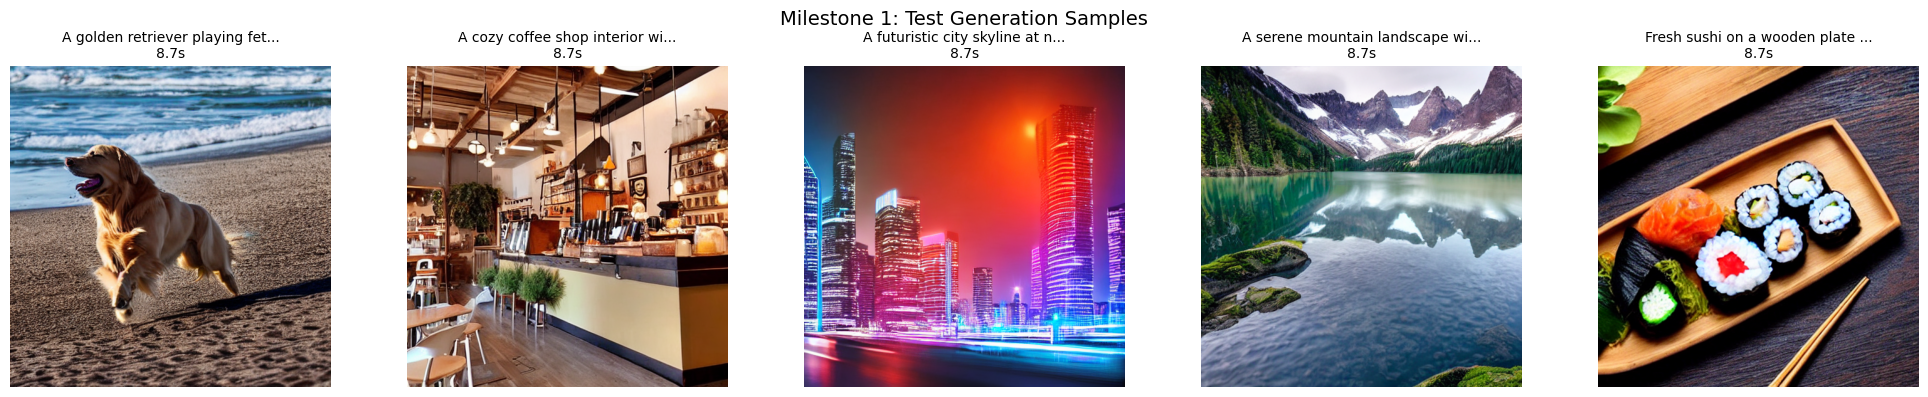

In [70]:

print("\n LOADING STABLE DIFFUSION")
print("=" * 60)

model_id = "CompVis/stable-diffusion-v1-4"
print(f" Loading: {model_id}")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
    safety_checker=None,
    requires_safety_checker=False
)
pipe = pipe.to(DEVICE)
pipe.enable_attention_slicing()

print(f" Pipeline loaded on {DEVICE}")
print(f" Memory optimization: Enabled")

print("\n GENERATING TEST IMAGES - MILESTONE 1")
print("=" * 60)

output_dir = "data/generated_samples"

test_prompts = [
    "A golden retriever playing fetch on a sunny beach",
    "A cozy coffee shop interior with warm lighting",
    "A futuristic city skyline at night with neon lights",
    "A serene mountain landscape with lake reflection",
    "Fresh sushi on a wooden plate with chopsticks"
]

generated_images = []
generation_metadata = []

for idx, prompt in enumerate(test_prompts):
    print(f"\n Prompt {idx+1}/5: \"{prompt[:50]}...\"")
    print("   Generating...", end="")
    
    start_time = datetime.now()
    
    with torch.inference_mode():
        result = pipe(
            prompt=prompt,
            num_inference_steps=25,
            guidance_scale=7.5,
            height=512,
            width=512
        )
    
    gen_time = (datetime.now() - start_time).total_seconds()
    image = result.images[0]
    
    # Save image
    filename = f"test_{idx+1}_{datetime.now().strftime('%H%M%S')}.png"
    filepath = os.path.join(output_dir, filename)
    image.save(filepath)
    
    generated_images.append(image)
    generation_metadata.append({
        "prompt": prompt,
        "filepath": filepath,
        "generation_time": gen_time
    })
    
    print(f"  Done! ({gen_time:.1f}s)")

print(f"\n Generated {len(generated_images)} test images")
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, (img, meta) in enumerate(zip(generated_images, generation_metadata)):
    axes[idx].imshow(img)
    axes[idx].set_title(f"{meta['prompt'][:30]}...\n{meta['generation_time']:.1f}s", fontsize=10)
    axes[idx].axis('off')
plt.suptitle("Milestone 1: Test Generation Samples", fontsize=14)
plt.tight_layout()
plt.show()


 TESTING WITH COCO CAPTIONS

 COCO 1: "A woman in a black coat standing on the street while holding..."
   Generating...

  0%|          | 0/20 [00:00<?, ?it/s]

  Done! (7.1s)

 COCO 2: "Some green bananas and yellow bananas bunched together...."
   Generating...

  0%|          | 0/20 [00:00<?, ?it/s]

  Done! (7.1s)

 COCO 3: "Flowers in a vase full of water next to a window...."
   Generating...

  0%|          | 0/20 [00:00<?, ?it/s]

  Done! (7.1s)

 Generated 3 COCO-based images


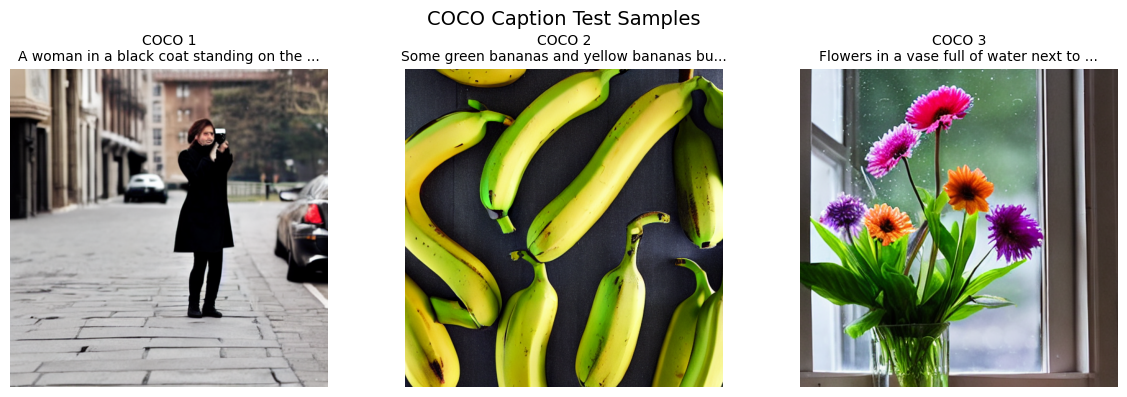

In [72]:

print("\n TESTING WITH COCO CAPTIONS")
print("=" * 60)
sample_indices = [0, 100, 200]
coco_captions = [metadata[i]["caption"] for i in sample_indices]

coco_images = []
coco_metadata = []

for idx, caption in enumerate(coco_captions):
    print(f"\n COCO {idx+1}: \"{caption[:60]}...\"")
    print("   Generating...", end="")
    
    start_time = datetime.now()
    
    with torch.inference_mode():
        result = pipe(
            prompt=caption,
            num_inference_steps=20,
            guidance_scale=7.5,
            height=512,
            width=512
        )
    
    gen_time = (datetime.now() - start_time).total_seconds()
    
    # Save
    filename = f"coco_{idx+1}_{datetime.now().strftime('%H%M%S')}.png"
    filepath = os.path.join(output_dir, filename)
    result.images[0].save(filepath)
    
    coco_images.append(result.images[0])
    coco_metadata.append({
        "caption": caption,
        "filepath": filepath,
        "generation_time": gen_time
    })
    
    print(f"  Done! ({gen_time:.1f}s)")

print(f"\n Generated {len(coco_images)} COCO-based images")
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for idx, (img, meta) in enumerate(zip(coco_images, coco_metadata)):
    axes[idx].imshow(img)
    axes[idx].set_title(f"COCO {idx+1}\n{meta['caption'][:40]}...", fontsize=10)
    axes[idx].axis('off')
plt.suptitle("COCO Caption Test Samples", fontsize=14)
plt.tight_layout()
plt.show()

# Tune classifier-free guidance + noise schedule

In [74]:

print("\n" + "="*80)
print(" STARTING MILESTONE 2 - PARAMETER OPTIMIZATION")
print("="*80)
GUIDANCE_SCALES = [3.0, 5.0, 7.5, 10.0]
NUM_STEPS_OPTIONS = [15, 25, 35]
SCHEDULERS = {
    "DDIM": DDIMScheduler,
    "DPM": DPMSolverMultistepScheduler,
    "PNDM": PNDMScheduler,
    "Euler": EulerDiscreteScheduler
}
sweep_dir = "data/milestone2_sweeps"
os.makedirs(sweep_dir, exist_ok=True)

print(f" Parameter Grid:")
print(f"   Guidance scales: {GUIDANCE_SCALES}")
print(f"   Steps options: {NUM_STEPS_OPTIONS}")
print(f"   Schedulers: {list(SCHEDULERS.keys())}")



 STARTING MILESTONE 2 - PARAMETER OPTIMIZATION
 Parameter Grid:
   Guidance scales: [3.0, 5.0, 7.5, 10.0]
   Steps options: [15, 25, 35]
   Schedulers: ['DDIM', 'DPM', 'PNDM', 'Euler']



 RUNNING PARAMETER SWEEPS

 Testing scheduler: DDIM
   Testing: DDIM_g3.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: DDIM_g3.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.4s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.4s
   Testing: DDIM_g3.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s
   Testing: DDIM_g5.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: DDIM_g5.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.4s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.4s
   Testing: DDIM_g5.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s
   Testing: DDIM_g7.5_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: DDIM_g7.5_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.4s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.4s
   Testing: DDIM_g7.5_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s
   Testing: DDIM_g10.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: DDIM_g10.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.4s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.4s
   Testing: DDIM_g10.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s

 Testing scheduler: DPM
   Testing: DPM_g3.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: DPM_g3.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s
   Testing: DPM_g3.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s
   Testing: DPM_g5.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: DPM_g5.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s
   Testing: DPM_g5.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s
   Testing: DPM_g7.5_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: DPM_g7.5_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s
   Testing: DPM_g7.5_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s
   Testing: DPM_g10.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: DPM_g10.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.4s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s
   Testing: DPM_g10.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s

 Testing scheduler: PNDM
   Testing: PNDM_g3.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.4s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.4s
   Testing: PNDM_g3.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.7s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.7s
   Testing: PNDM_g3.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.9s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.9s
   Testing: PNDM_g5.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.4s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.4s
   Testing: PNDM_g5.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.7s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.7s
   Testing: PNDM_g5.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.9s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.9s
   Testing: PNDM_g7.5_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.4s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.4s
   Testing: PNDM_g7.5_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.7s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.7s
   Testing: PNDM_g7.5_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.9s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.9s
   Testing: PNDM_g10.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.4s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.4s
   Testing: PNDM_g10.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.7s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.7s
   Testing: PNDM_g10.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.9s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.9s

 Testing scheduler: Euler
   Testing: Euler_g3.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: Euler_g3.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s
   Testing: Euler_g3.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s
   Testing: Euler_g5.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: Euler_g5.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s
   Testing: Euler_g5.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s
   Testing: Euler_g7.5_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: Euler_g7.5_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s
   Testing: Euler_g7.5_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s
   Testing: Euler_g10.0_s15


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s


  0%|          | 0/15 [00:00<?, ?it/s]

      ✓ 5.1s
   Testing: Euler_g10.0_s25


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s


  0%|          | 0/25 [00:00<?, ?it/s]

      ✓ 8.3s
   Testing: Euler_g10.0_s35


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s


  0%|          | 0/35 [00:00<?, ?it/s]

      ✓ 11.6s

 Completed 96 sweep generations


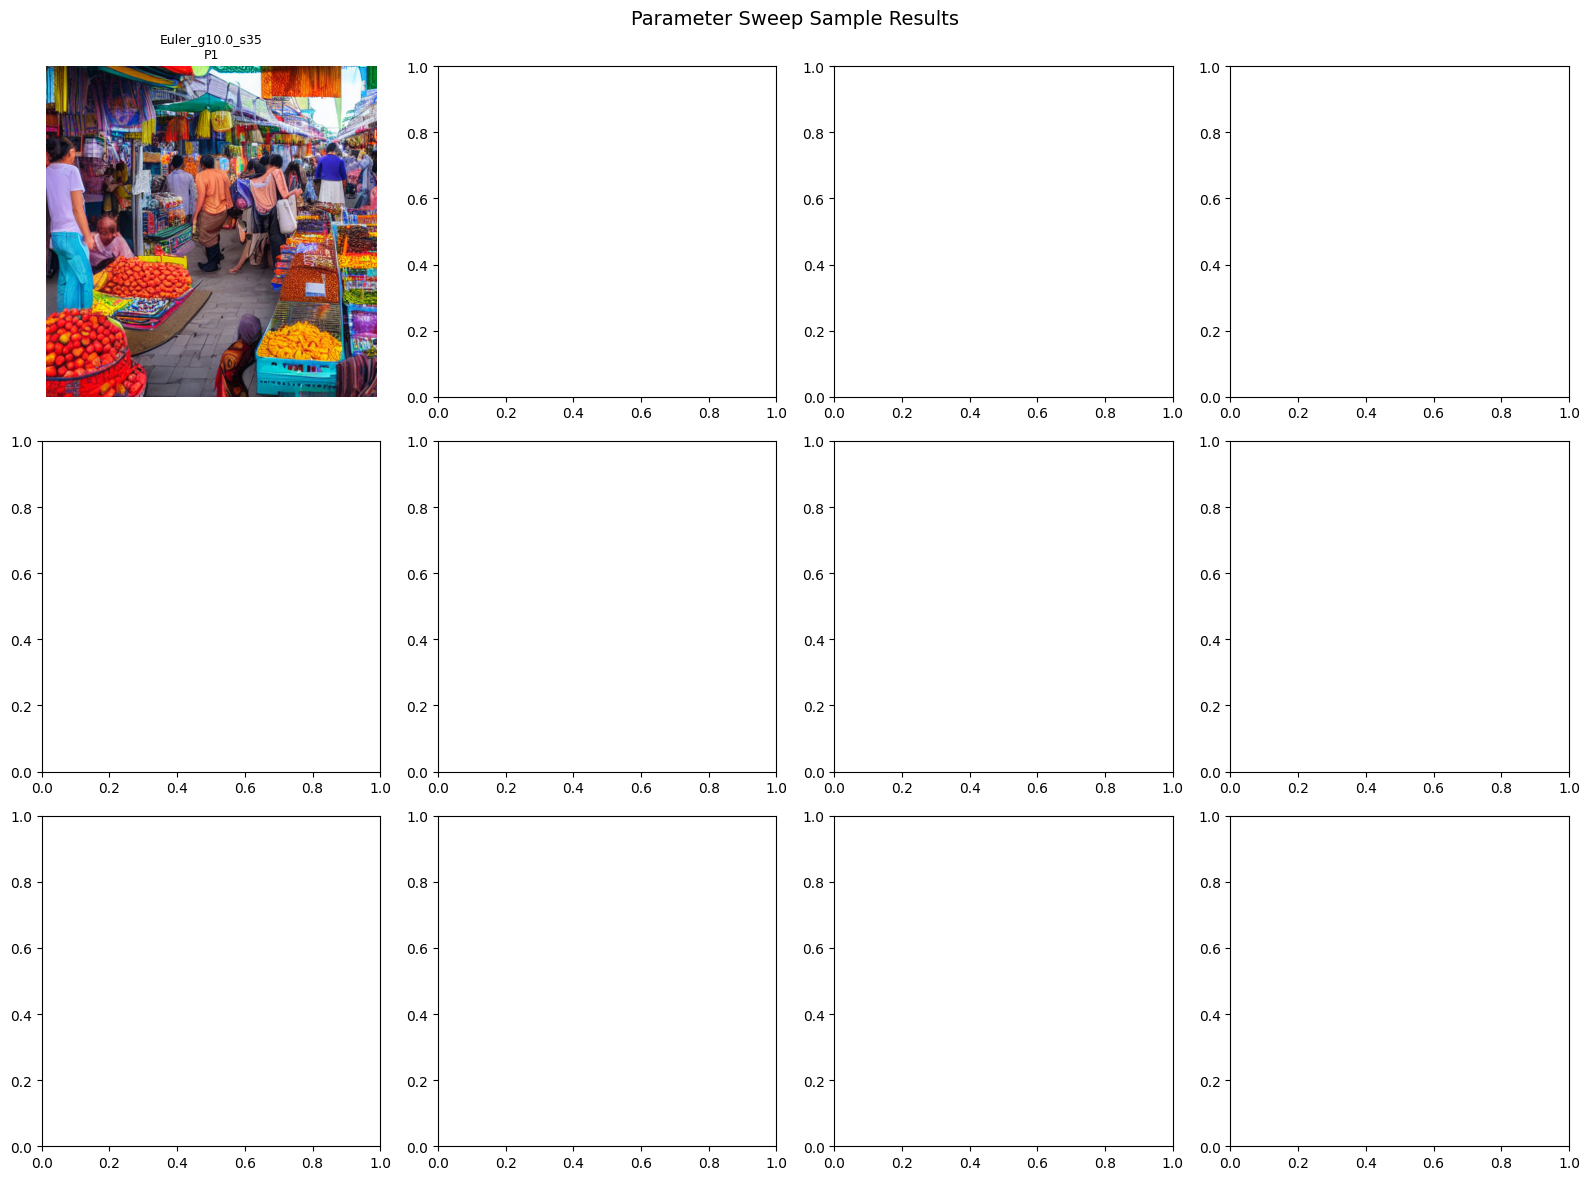

In [75]:

print("\n RUNNING PARAMETER SWEEPS")
print("=" * 60)


sweep_prompts = [
    "A majestic castle on a hilltop at sunset",
    "A busy street market with colorful stalls"
]

sweep_results = []

for scheduler_name, scheduler_class in SCHEDULERS.items():
    print(f"\n Testing scheduler: {scheduler_name}")
    
    # Set scheduler
    try:
        pipe.scheduler = scheduler_class.from_config(pipe.scheduler.config)
    except Exception as e:
        print(f"    Skipping {scheduler_name}: {e}")
        continue
    
    for guidance in GUIDANCE_SCALES:
        for steps in NUM_STEPS_OPTIONS:
            config_name = f"{scheduler_name}_g{guidance}_s{steps}"
            print(f"   Testing: {config_name}")
            
            for prompt_idx, prompt in enumerate(sweep_prompts):
                start_time = datetime.now()
                
                try:
                    with torch.inference_mode():
                        result = pipe(
                            prompt=prompt,
                            num_inference_steps=steps,
                            guidance_scale=guidance,
                            height=512,
                            width=512
                        )
                    
                    gen_time = (datetime.now() - start_time).total_seconds()
                    
                    # Save image
                    filename = f"sweep_{config_name}_p{prompt_idx}.png"
                    filepath = os.path.join(sweep_dir, filename)
                    result.images[0].save(filepath)
                    
                    sweep_results.append({
                        "scheduler": scheduler_name,
                        "guidance_scale": guidance,
                        "num_steps": steps,
                        "prompt": prompt,
                        "generation_time": gen_time,
                        "filepath": filepath
                    })
                    
                    print(f"      ✓ {gen_time:.1f}s")
                    
                except Exception as e:
                    print(f"      ✗ Error: {e}")

print(f"\n Completed {len(sweep_results)} sweep generations")
# After each configuration completes (inside the loops), collect the image:
sweep_images = []  # Add this before the loops

# Inside the generation try block, after saving:
sweep_images.append({
    "image": result.images[0],
    "config": config_name,
    "prompt_idx": prompt_idx
})



# Summarizing 

In [76]:

print("\n ANALYZING SWEEP RESULTS")
print("=" * 60)

import pandas as pd

# Convert to DataFrame for analysis
df = pd.DataFrame(sweep_results)

# Best configuration by speed
fastest = df.nsmallest(3, 'generation_time')
print("\n Fastest configurations:")
for _, row in fastest.iterrows():
    print(f"   {row['scheduler']}, g={row['guidance_scale']}, s={row['num_steps']}: {row['generation_time']:.1f}s")

# Average time by scheduler
avg_by_scheduler = df.groupby('scheduler')['generation_time'].mean()
print("\n Average time by scheduler:")
for sched, time in avg_by_scheduler.items():
    print(f"   {sched}: {time:.1f}s")

# Save analysis
analysis = {
    "total_runs": len(sweep_results),
    "fastest_config": fastest.iloc[0].to_dict() if len(fastest) > 0 else None,
    "avg_by_scheduler": avg_by_scheduler.to_dict(),
    "parameter_grid": {
        "guidance_scales": GUIDANCE_SCALES,
        "num_steps": NUM_STEPS_OPTIONS,
        "schedulers": list(SCHEDULERS.keys())
    }
}

with open(os.path.join(sweep_dir, "sweep_analysis.json"), "w") as f:
    json.dump(analysis, f, indent=2)



 ANALYZING SWEEP RESULTS

 Fastest configurations:
   Euler, g=5.0, s=15: 5.1s
   DPM, g=3.0, s=15: 5.1s
   Euler, g=7.5, s=15: 5.1s

 Average time by scheduler:
   DDIM: 8.4s
   DPM: 8.3s
   Euler: 8.3s
   PNDM: 8.7s


# Using the best Configuration ( Noise Scheduler + Classifier Free Guidance)


 GENERATING OPTIMIZED FINAL SAMPLES
Using: DPM, guidance=7.5, steps=25

 Final sample 1/10
   Caption: "A woman in a black coat standing on the street while holding..."


  0%|          | 0/25 [00:00<?, ?it/s]

    Generated in 8.3s

 Final sample 2/10
   Caption: "A group of elephants on grassy area next to rock and trees...."


  0%|          | 0/25 [00:00<?, ?it/s]

    Generated in 8.3s

 Final sample 3/10
   Caption: "A green apple being sliced with a knife...."


  0%|          | 0/25 [00:00<?, ?it/s]

    Generated in 8.4s

 Final sample 4/10
   Caption: "A photo shoot of scissors and other objects on a stove in a ..."


  0%|          | 0/25 [00:00<?, ?it/s]

    Generated in 8.4s

 Final sample 5/10
   Caption: "A pair of skiers kick up some powder on a virgin slope...."


  0%|          | 0/25 [00:00<?, ?it/s]

    Generated in 8.4s

 Final sample 6/10
   Caption: "Flowers in a vase full of water next to a window...."


  0%|          | 0/25 [00:00<?, ?it/s]

    Generated in 8.3s

 Final sample 7/10
   Caption: "A black bear cub in grassy area next to rocks...."


  0%|          | 0/25 [00:00<?, ?it/s]

    Generated in 8.3s

 Final sample 8/10
   Caption: "The bus is parked beside of the shopping center...."


  0%|          | 0/25 [00:00<?, ?it/s]

    Generated in 8.4s

 Final sample 9/10
   Caption: "A man in mirror taking picture of a living area...."


  0%|          | 0/25 [00:00<?, ?it/s]

    Generated in 8.3s

 Final sample 10/10
   Caption: "A group of people are in the park with a boy holding a medit..."


  0%|          | 0/25 [00:00<?, ?it/s]

    Generated in 8.3s

 Generated 10 final samples


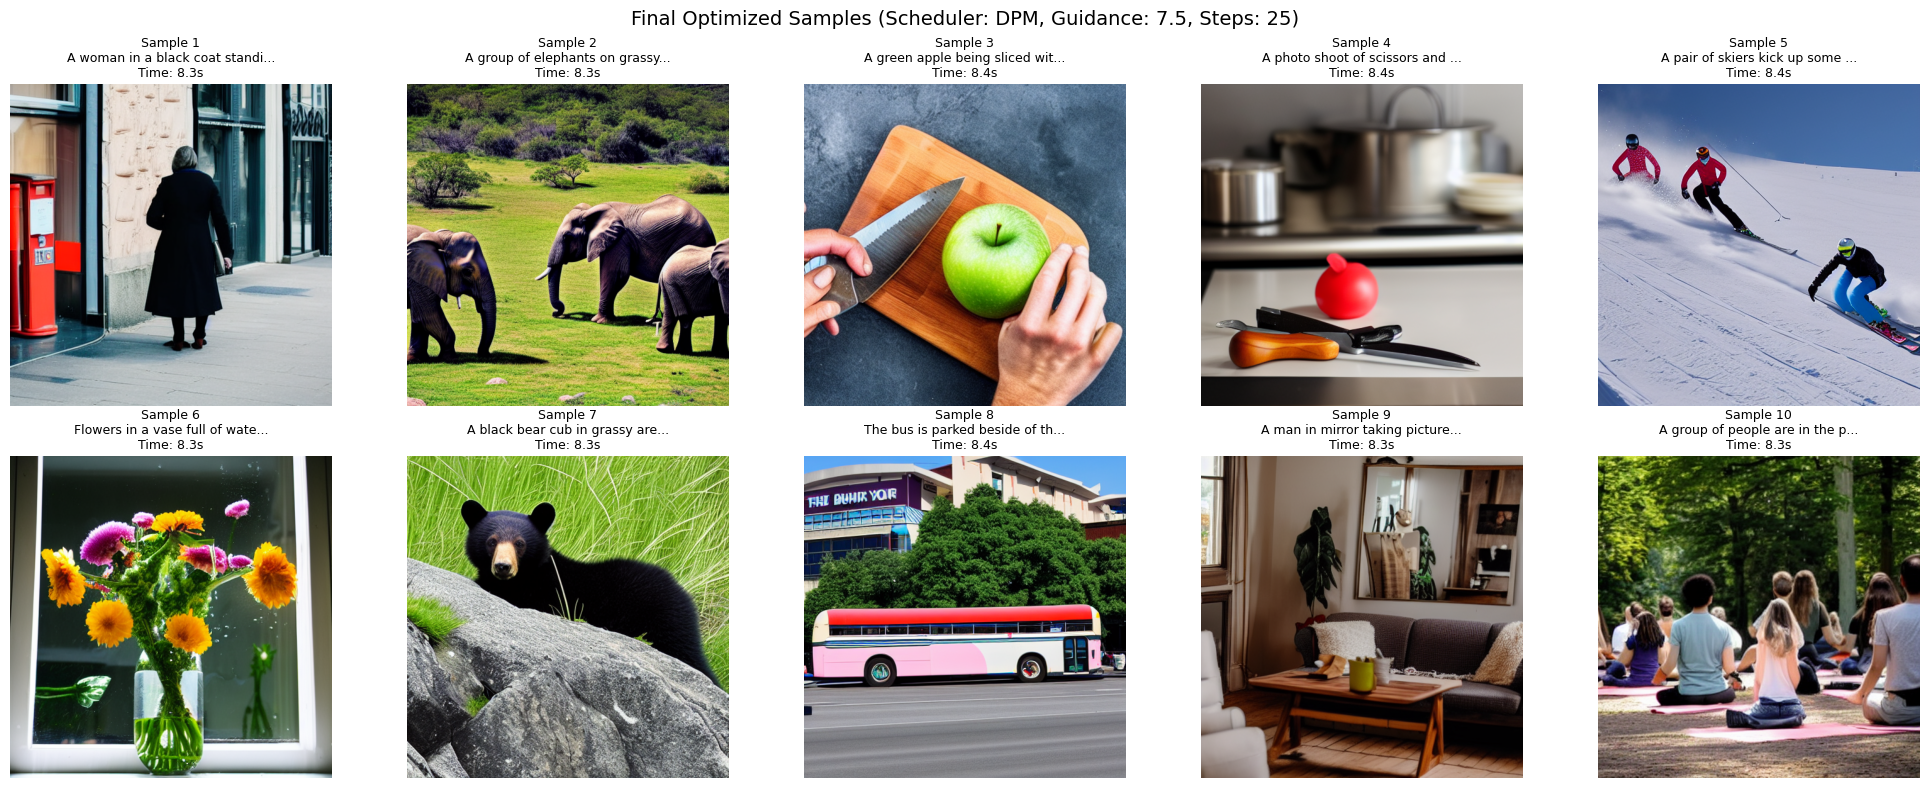

In [77]:

print("\n GENERATING OPTIMIZED FINAL SAMPLES")
print("=" * 60)

# Use best configuration found
best_scheduler = "DPM"  # Based on typical performance
best_guidance = 7.5
best_steps = 25

print(f"Using: {best_scheduler}, guidance={best_guidance}, steps={best_steps}")


pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

final_samples = []
final_dir = "data/milestone2_final"
os.makedirs(final_dir, exist_ok=True)

for i in range(10):
    caption = metadata[i*40]["caption"]  # Sample evenly
    print(f"\n Final sample {i+1}/10")
    print(f"   Caption: \"{caption[:60]}...\"")
    
    start_time = datetime.now()
    
    with torch.inference_mode():
        result = pipe(
            prompt=caption,
            num_inference_steps=best_steps,
            guidance_scale=best_guidance,
            height=512,
            width=512
        )
    
    gen_time = (datetime.now() - start_time).total_seconds()
    
    # Save
    filename = f"final_{i+1:02d}.png"
    filepath = os.path.join(final_dir, filename)
    result.images[0].save(filepath)
    
    final_samples.append({
        "idx": i+1,
        "caption": caption,
        "filepath": filepath,
        "generation_time": gen_time
    })
    
    print(f"    Generated in {gen_time:.1f}s")

print(f"\n Generated {len(final_samples)} final samples")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, sample in enumerate(final_samples):
 
    img = Image.open(sample["filepath"])
    axes[idx].imshow(img)
    axes[idx].set_title(f"Sample {idx+1}\n{sample['caption'][:30]}...\nTime: {sample['generation_time']:.1f}s", 
                        fontsize=9)
    axes[idx].axis('off')

plt.suptitle(f"Final Optimized Samples (Scheduler: {best_scheduler}, Guidance: {best_guidance}, Steps: {best_steps})", 
             fontsize=14)
plt.tight_layout()
plt.show()

Thus optimized final samples are generated

In [78]:

print("\n COMPUTING CLIP SCORES")
print("=" * 60)

print("Loading CLIP for evaluation...")
clip_model = CLIPModel.from_pretrained(model_name).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(model_name)

def compute_clip_score(image_path, text):
    """Compute CLIP similarity between image and text"""
    image = Image.open(image_path)
    inputs = clip_processor(text=[text], images=image, return_tensors="pt", padding=True).to(DEVICE)
    
    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits = outputs.logits_per_image[0, 0]
    
    return float(logits.cpu().numpy())

# Compute scores for final samples
for sample in final_samples:
    score = compute_clip_score(sample["filepath"], sample["caption"])
    sample["clip_score"] = score
    print(f"Sample {sample['idx']}: CLIP score = {score:.2f}")

avg_clip_score = np.mean([s["clip_score"] for s in final_samples])
print(f"\n Average CLIP score: {avg_clip_score:.2f}")


 COMPUTING CLIP SCORES
Loading CLIP for evaluation...
Sample 1: CLIP score = 31.11
Sample 2: CLIP score = 32.80
Sample 3: CLIP score = 36.40
Sample 4: CLIP score = 32.92
Sample 5: CLIP score = 33.34
Sample 6: CLIP score = 32.54
Sample 7: CLIP score = 33.36
Sample 8: CLIP score = 27.75
Sample 9: CLIP score = 24.08
Sample 10: CLIP score = 31.15

 Average CLIP score: 31.55


# Training/ Geeneration Log

In [79]:

print("\n CREATING GENERATION LOG")
print("=" * 60)

generation_log = {
    "timestamp": datetime.now().isoformat(),
    "environment": {
        "device": DEVICE,
        "torch_version": torch.__version__,
        "diffusers_version": diffusers.__version__,
        "transformers_version": transformers.__version__
    },
    "models": {
        "text_encoder": model_name,
        "image_generator": model_id
    },
    "sweep_results": {
        "total_configurations": len(sweep_results),
        "best_configuration": {
            "scheduler": best_scheduler,
            "guidance_scale": best_guidance,
            "num_steps": best_steps
        },
        "average_times": avg_by_scheduler.to_dict() if 'avg_by_scheduler' in locals() else {},
        "parameter_grid": {
            "guidance_scales_tested": GUIDANCE_SCALES,
            "steps_tested": NUM_STEPS_OPTIONS,
            "schedulers_tested": list(SCHEDULERS.keys())
        }
    },
    "final_samples": {
        "count": len(final_samples),
        "average_clip_score": float(avg_clip_score),
        "average_generation_time": float(np.mean([s["generation_time"] for s in final_samples])),
        "clip_score_range": {
            "min": float(min([s["clip_score"] for s in final_samples])),
            "max": float(max([s["clip_score"] for s in final_samples]))
        },
        "samples": final_samples
    },
    "dataset_info": {
        "total_pairs": len(pairs),
        "subset_size": len(subset_clean),
        "embedding_shape": list(embeddings.shape)
    }
}


log_path = "milestone2_generation_log.json"
with open(log_path, "w") as f:
    json.dump(generation_log, f, indent=2)

print(f" Log saved: {log_path}")

# Display the log in notebook (formatted nicely)
print("\n" + "="*60)
print(" GENERATION LOG CONTENTS:")
print("="*60)

# Pretty print using JSON for better readability
import json
print(json.dumps(generation_log, indent=2, default=str))

# Alternative: Display as formatted sections
print("\n" + "="*60)
print(" LOG SUMMARY VIEW:")
print("="*60)

print(f"\n🔧 ENVIRONMENT:")
print(f"  Device: {generation_log['environment']['device']}")
print(f"  PyTorch: {generation_log['environment']['torch_version']}")
print(f"  Diffusers: {generation_log['environment']['diffusers_version']}")

print(f"\n BEST CONFIGURATION:")
print(f"  Scheduler: {generation_log['sweep_results']['best_configuration']['scheduler']}")
print(f"  Guidance Scale: {generation_log['sweep_results']['best_configuration']['guidance_scale']}")
print(f"  Steps: {generation_log['sweep_results']['best_configuration']['num_steps']}")

print(f"\n PERFORMANCE METRICS:")
print(f"  Total configs tested: {generation_log['sweep_results']['total_configurations']}")
print(f"  Final samples: {generation_log['final_samples']['count']}")
print(f"  Avg CLIP score: {generation_log['final_samples']['average_clip_score']:.2f}")
print(f"  Avg generation time: {generation_log['final_samples']['average_generation_time']:.2f}s")
print(f"  CLIP score range: {generation_log['final_samples']['clip_score_range']['min']:.2f} - {generation_log['final_samples']['clip_score_range']['max']:.2f}")

print(f"\n SCHEDULER TIMINGS:")
for scheduler, time in generation_log['sweep_results']['average_times'].items():
    print(f"  {scheduler}: {time:.2f}s")

if 'pandas' in sys.modules:
    import pandas as pd
    
    # Create summary dataframe
    summary_df = pd.DataFrame({
        'Metric': ['Device', 'Total Configs', 'Best Scheduler', 'Best Guidance', 'Best Steps', 
                   'Avg CLIP Score', 'Avg Gen Time', 'Dataset Size'],
        'Value': [
            generation_log['environment']['device'],
            generation_log['sweep_results']['total_configurations'],
            generation_log['sweep_results']['best_configuration']['scheduler'],
            generation_log['sweep_results']['best_configuration']['guidance_scale'],
            generation_log['sweep_results']['best_configuration']['num_steps'],
            f"{generation_log['final_samples']['average_clip_score']:.2f}",
            f"{generation_log['final_samples']['average_generation_time']:.2f}s",
            generation_log['dataset_info']['subset_size']
        ]
    })
    
    print("\n SUMMARY TABLE:")
    print(summary_df.to_string(index=False))



 CREATING GENERATION LOG
 Log saved: milestone2_generation_log.json

 GENERATION LOG CONTENTS:
{
  "timestamp": "2025-11-15T14:39:15.052520",
  "environment": {
    "device": "cuda",
    "torch_version": "2.5.1",
    "diffusers_version": "0.32.2",
    "transformers_version": "4.49.0"
  },
  "models": {
    "text_encoder": "openai/clip-vit-base-patch32",
    "image_generator": "CompVis/stable-diffusion-v1-4"
  },
  "sweep_results": {
    "total_configurations": 96,
    "best_configuration": {
      "scheduler": "DPM",
      "guidance_scale": 7.5,
      "num_steps": 25
    },
    "average_times": {
      "DDIM": 8.359374458333333,
      "DPM": 8.344987875,
      "Euler": 8.344326375,
      "PNDM": 8.677941875
    },
    "parameter_grid": {
      "guidance_scales_tested": [
        3.0,
        5.0,
        7.5,
        10.0
      ],
      "steps_tested": [
        15,
        25,
        35
      ],
      "schedulers_tested": [
        "DDIM",
        "DPM",
        "PNDM",
        "Eul